In [ ]:
!pip install scienceplots mne  braindecode

In [1]:
import os
import requests
import zipfile
import numpy as np
from tqdm import tqdm
import pandas as pd
from typing import Tuple, Dict
import matplotlib.pyplot as plt
import mne
import seaborn as sns
import time
import scienceplots
from sklearn.decomposition import PCA
plt.style.use(["science", "notebook", "grid"])
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.stats import ttest_rel, ttest_ind, kruskal, mannwhitneyu
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from torch.utils.data import  TensorDataset, DataLoader
from braindecode.models import ATCNet, EEGNetv4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# Ignore pandas version warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pandas")
warnings.filterwarnings('ignore')

# Silence MNE warnings
mne.set_log_level('WARNING')

# Filter specific warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Step 1: Downloading the Data
---
Use download the dataset from the provided URL https://physionet.org/static/published-projects/eegmat/eeg-during-mental-arithmetic-tasks-1.0.0.zip using the `requests` library.
After downloading, unzip the dataset into a designated folder using the `zipfile` library.


In [90]:
def download_file(url: str, dest_folder: str) -> str:
    """
    Downloads a file from the specified URL and saves it to the destination folder.

    Parameters:
    url (str): URL of the file to be downloaded.
    dest_folder (str): The folder where the downloaded file will be saved.

    Returns:
    str: The path to the downloaded file.
    """
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)
    local_filename = os.path.join(dest_folder, url.split('/')[-1])
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    chunk_size = 1024
    with open(local_filename, 'wb') as file, tqdm(
        desc=local_filename,
        total=total_size,
        unit='B',
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for data in response.iter_content(chunk_size=chunk_size):
            file.write(data)
            bar.update(len(data))
    return local_filename

def unzip_file(zip_filepath: str, dest_folder: str) -> None:
    """
    Unzips a zip file to the specified destination folder.

    Parameters:
    zip_filepath (str): The path to the zip file to be unzipped.
    dest_folder (str): The folder where the contents will be extracted.
    """
    with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
        zip_ref.extractall(dest_folder)
    print(f"Extracted to {dest_folder}")

    # Delete the zip file after extraction
    os.remove(zip_filepath)

In [ ]:
# URL of the dataset zip file
url = "https://physionet.org/static/published-projects/eegmat/eeg-during-mental-arithmetic-tasks-1.0.0.zip"
dest_folder = "eegmat_dataset"

# Download and unzip the dataset
zip_filepath = download_file(url, dest_folder)
unzip_file(zip_filepath, dest_folder)

print("Download and extraction complete.")

Now, let's define a general function to read EDF files for both the rest and task states for multiple subjects.

In [2]:
# Load subject information
subject_info = pd.read_csv('eegmat_dataset/eeg-during-mental-arithmetic-tasks-1.0.0/subject-info.csv')

def read_edf(file_path: str) -> Tuple[np.ndarray, np.ndarray]:
    """
    Reads an EDF file using MNE and extracts signal labels and data.

    Parameters:
    file_path (str): Path to the EDF file.

    Returns:
    Tuple[np.ndarray, np.ndarray]: A tuple containing the signal labels and the signals.
    """
    raw = mne.io.read_raw_edf(file_path, preload=True)
    signal_labels = np.array(raw.ch_names)
    signals = raw.get_data()
    return signal_labels, signals

# Example usage for a specific subject
rest_file_path = 'eegmat_dataset/eeg-during-mental-arithmetic-tasks-1.0.0/Subject00_1.edf'
task_file_path = 'eegmat_dataset/eeg-during-mental-arithmetic-tasks-1.0.0/Subject00_2.edf'

rest_labels, rest_signals = read_edf(rest_file_path)
task_labels, task_signals = read_edf(task_file_path)

print(f"Rest Labels: {rest_labels}")
print(f"Task Labels: {task_labels}")
print(f"Rest Signals Shape: {rest_signals.shape}")
print(f"Task Signals Shape: {task_signals.shape}")

Rest Labels: ['EEG Fp1' 'EEG Fp2' 'EEG F3' 'EEG F4' 'EEG F7' 'EEG F8' 'EEG T3' 'EEG T4'
 'EEG C3' 'EEG C4' 'EEG T5' 'EEG T6' 'EEG P3' 'EEG P4' 'EEG O1' 'EEG O2'
 'EEG Fz' 'EEG Cz' 'EEG Pz' 'EEG A2-A1' 'ECG ECG']
Task Labels: ['EEG Fp1' 'EEG Fp2' 'EEG F3' 'EEG F4' 'EEG F7' 'EEG F8' 'EEG T3' 'EEG T4'
 'EEG C3' 'EEG C4' 'EEG T5' 'EEG T6' 'EEG P3' 'EEG P4' 'EEG O1' 'EEG O2'
 'EEG Fz' 'EEG Cz' 'EEG Pz' 'EEG A2-A1' 'ECG ECG']
Rest Signals Shape: (21, 91000)
Task Signals Shape: (21, 31000)


Next, we will define a function to calculate the PSD for given signals using Welch's method.

In [3]:
def compute_psd(signals: np.ndarray, sfreq: float = 256) -> Dict[str, float]:
    """
    Computes the Power Spectral Density (PSD) for given signals using MNE's psd_array_welch method.

    Parameters:
    signals (np.ndarray): Array of signals to compute PSD for (channels x time).
    sfreq (float): Sampling frequency of the signals.

    Returns:
    Dict[str, float]: A dictionary containing the mean PSD for different frequency bands.
    """
    psd = {'Delta': [], 'Theta': [], 'Alpha': [], 'Beta': [], 'Gamma': []}
    fmin = {'Delta': 1, 'Theta': 4, 'Alpha': 8, 'Beta': 12, 'Gamma': 30}
    fmax = {'Delta': 4, 'Theta': 8, 'Alpha': 12, 'Beta': 30, 'Gamma': 100}

    for i in range(signals.shape[0]):  # Iterate over each channel
        psds, freqs = mne.time_frequency.psd_array_welch(signals[i], sfreq=sfreq, fmin=1, fmax=100, n_fft=2048)
        for band in psd.keys():
            band_psd = np.mean(psds[(freqs >= fmin[band]) & (freqs < fmax[band])])
            psd[band].append(band_psd)

    # Compute mean PSD for each band across all channels
    psd_mean = {band: np.mean(values) for band, values in psd.items()}
    return psd_mean


# Example usage for rest and task signals
rest_psd = compute_psd(rest_signals)
task_psd = compute_psd(task_signals)

print(f"Rest PSD: {rest_psd}")
print(f"Task PSD: {task_psd}")

Rest PSD: {'Delta': 1.2320162634929957e-10, 'Theta': 6.923267876536374e-11, 'Alpha': 1.8294410293065055e-11, 'Beta': 1.235812444572968e-12, 'Gamma': 1.729471119216487e-16}
Task PSD: {'Delta': 9.268166308541494e-11, 'Theta': 7.648857123547682e-11, 'Alpha': 1.9775042380298968e-11, 'Beta': 1.422520341543097e-12, 'Gamma': 1.02086931387927e-15}


# Step 2: PSD Analysis of data
---

#### Step 2.1: Calculate and Compare PSDs for All Subjects

We need to iterate over all subjects, calculate the PSD for both rest and task states, and then compare them.

In [4]:
def process_all_subjects(subject_info: pd.DataFrame, base_path: str) -> pd.DataFrame:
    """
    Processes all subjects, calculates PSD for rest and task states, and stores the results.

    Parameters:
    subject_info (pd.DataFrame): DataFrame containing subject information.
    base_path (str): Base path where the EDF files are stored.

    Returns:
    pd.DataFrame: DataFrame containing PSD values for each subject.
    """
    results = []
    for idx, row in subject_info.iterrows():
        subject_id = row['Subject']
        rest_file_path = f"{base_path}/{subject_id}_1.edf"
        task_file_path = f"{base_path}/{subject_id}_2.edf"

        rest_labels, rest_signals = read_edf(rest_file_path)
        task_labels, task_signals = read_edf(task_file_path)

        rest_psd = compute_psd(rest_signals)
        task_psd = compute_psd(task_signals)

        result = {
            'Subject ID': subject_id,
            "Age": row['Age'],
            "Gender": row["Gender"],
            "Recording_year": row["Recording year"],
            "No_subtractions": row["Number of subtractions"],
            "Count_quality": row["Count quality"],
            'Group': row['Count quality'],
            'Rest Delta': rest_psd['Delta'],
            'Rest Theta': rest_psd['Theta'],
            'Rest Alpha': rest_psd['Alpha'],
            'Rest Beta': rest_psd['Beta'],
            'Rest Gamma': rest_psd['Gamma'],
            'Task Delta': task_psd['Delta'],
            'Task Theta': task_psd['Theta'],
            'Task Alpha': task_psd['Alpha'],
            'Task Beta': task_psd['Beta'],
            'Task Gamma': task_psd['Gamma']
        }
        results.append(result)

    return pd.DataFrame(results)

base_path = "eegmat_dataset/eeg-during-mental-arithmetic-tasks-1.0.0"
psd_results = process_all_subjects(subject_info, base_path)
psd_results.to_csv("psd_results.csv", index=False)

psd_results.head()

,Subject ID,Age,Gender,Recording_year,No_subtractions,Count_quality,Group,Rest Delta,Rest Theta,Rest Alpha,Rest Beta,Rest Gamma,Task Delta,Task Theta,Task Alpha,Task Beta,Task Gamma
0,Subject00,21,F,2011,9.70,0,0,1.232016e-10,6.923268e-11,1.829441e-11,1.235812e-12,1.729471e-16,9.268166e-11,7.648857e-11,1.977504e-11,1.422520e-12,1.020869e-15
1,Subject01,18,F,2011,29.35,1,1,5.177369e-11,2.151618e-11,7.927622e-12,1.058235e-12,3.221755e-15,5.086950e-11,1.605847e-11,6.688755e-12,1.358794e-12,7.199764e-15
2,Subject02,19,F,2012,12.88,1,1,1.277914e-11,1.069055e-11,2.771084e-12,5.559594e-13,2.210634e-15,4.357515e-11,2.685214e-11,1.950538e-11,3.306853e-12,4.634151e-15
3,Subject03,17,F,2010,31.00,1,1,3.791166e-11,3.013317e-11,8.180633e-12,8.620945e-13,1.114138e-16,3.373544e-11,2.049798e-11,8.308986e-12,9.193259e-13,3.318080e-16
4,Subject04,17,F,2010,8.60,0,0,6.101237e-11,3.001113e-11,1.285943e-11,1.454052e-12,3.175931e-15,5.141840e-11,2.742002e-11,1.311182e-11,7.903694e-13,9.025880e-16


## Step 2.2: Exploratory and Inferential Data Analysis

### Step 2.2.1 Summary Statistics

Let's start by calculating the summary statistics for the PSD values across different frequency bands for both rest and task states.

In [5]:
# Summary statistics for rest and task states
rest_psd_cols = ['Rest Delta', 'Rest Theta', 'Rest Alpha', 'Rest Beta', 'Rest Gamma']
task_psd_cols = ['Task Delta', 'Task Theta', 'Task Alpha', 'Task Beta', 'Task Gamma']

rest_summary = psd_results[rest_psd_cols].describe()
task_summary = psd_results[task_psd_cols].describe()


rest_summary, task_summary

(         Rest Delta    Rest Theta    Rest Alpha     Rest Beta    Rest Gamma
 count  3.600000e+01  3.600000e+01  3.600000e+01  3.600000e+01  3.600000e+01
 mean   7.980768e-11  4.183426e-11  1.944165e-11  1.819017e-12  1.302223e-15
 std    4.876456e-11  2.334076e-11  1.300638e-11  1.264860e-12  1.193651e-15
 min    6.797017e-12  2.140671e-12  7.848539e-13  2.017752e-13  5.158041e-17
 25%    5.086492e-11  2.254534e-11  8.117380e-12  8.609817e-13  4.943525e-16
 50%    7.271362e-11  3.619577e-11  1.754497e-11  1.691518e-12  8.937452e-16
 75%    9.605959e-11  5.739709e-11  2.648183e-11  2.409261e-12  1.750414e-15
 max    2.667323e-10  9.900776e-11  5.271517e-11  5.420489e-12  5.267567e-15,
          Task Delta    Task Theta    Task Alpha     Task Beta    Task Gamma
 count  3.600000e+01  3.600000e+01  3.600000e+01  3.600000e+01  3.600000e+01
 mean   6.606551e-11  4.052454e-11  2.063616e-11  2.024413e-12  2.111052e-15
 std    3.503250e-11  2.635268e-11  1.459091e-11  1.467590e-12  1.784343e-1

### Step 2.2.2 Distribution of PSD Values
We visualize the distribution of PSD values across different frequency bands using histograms and box plots

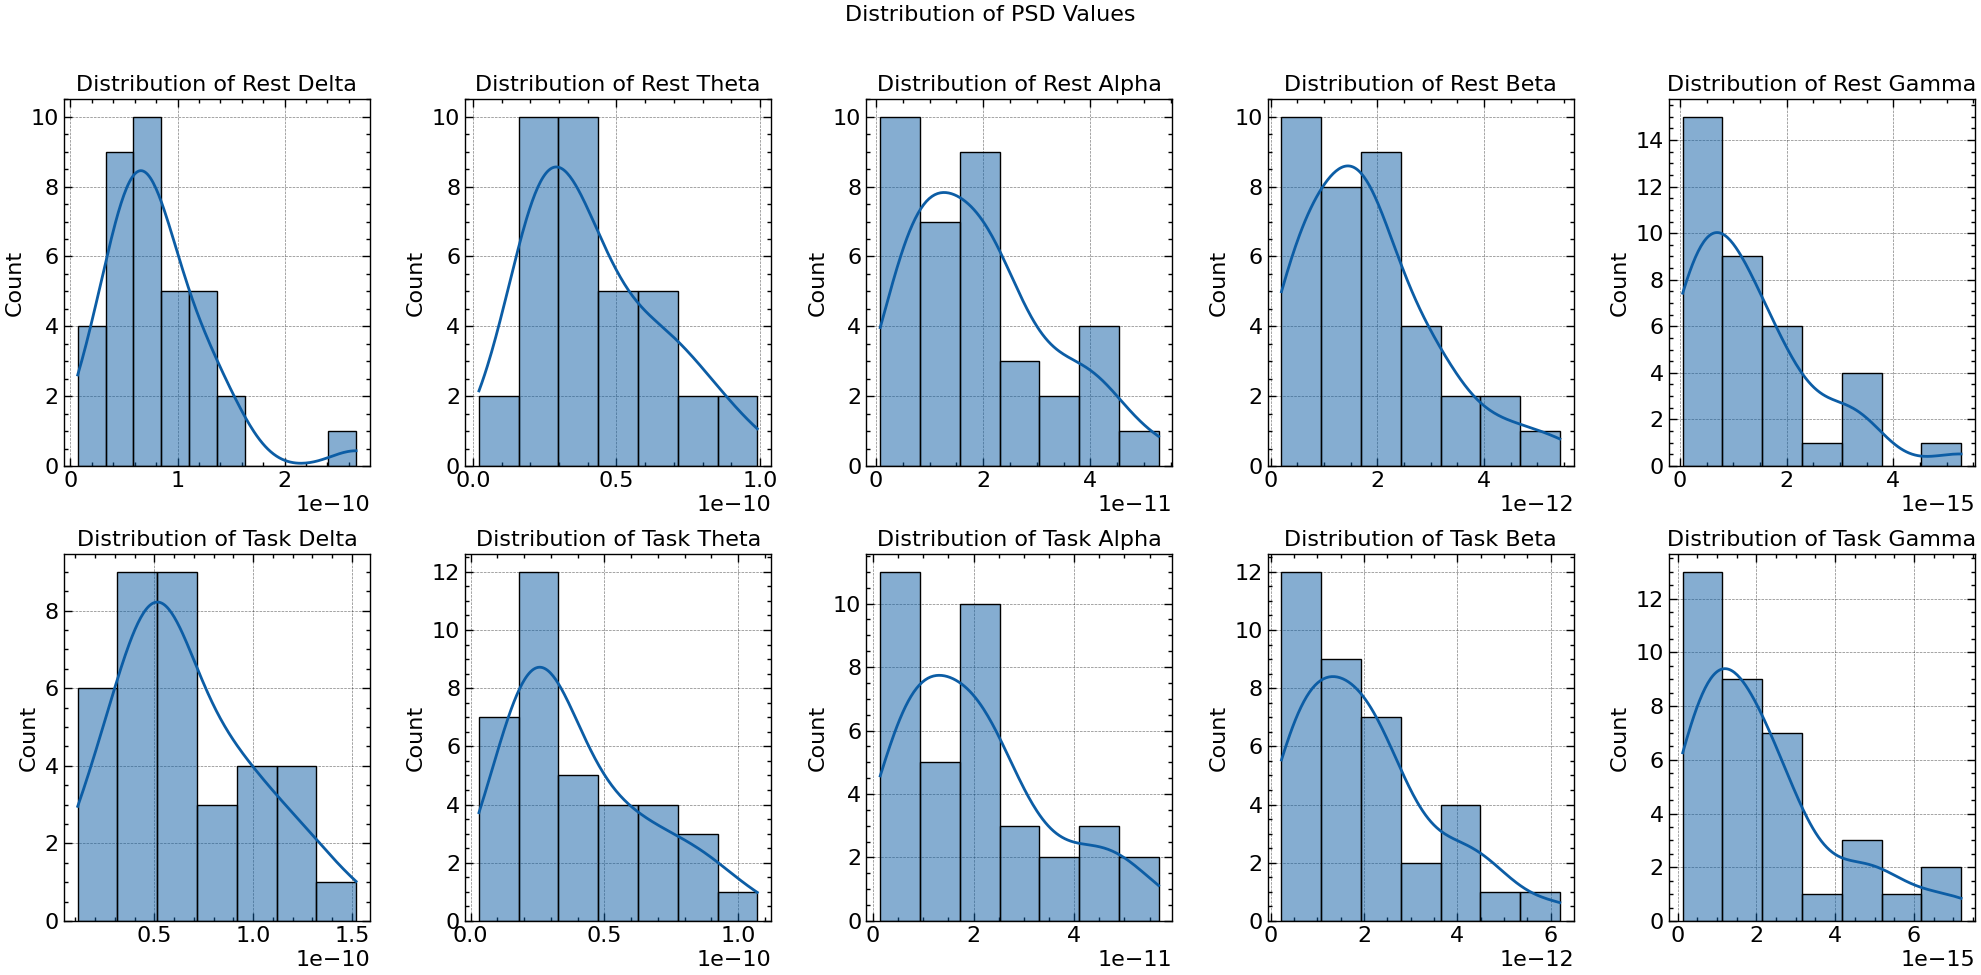

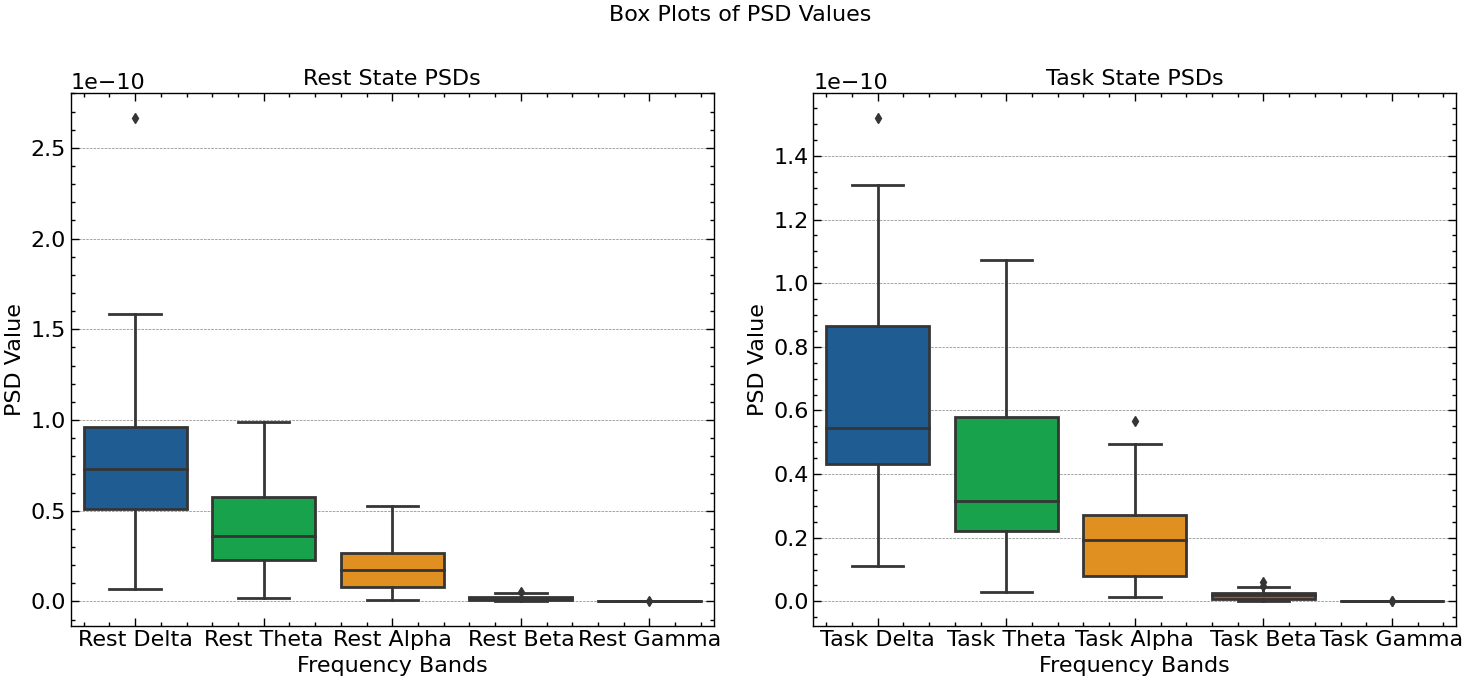

In [6]:
# Histograms
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
fig.suptitle('Distribution of PSD Values', fontsize=16)

for i, col in enumerate(rest_psd_cols):
    sns.histplot(psd_results[col], ax=axes[0, i], kde=True)
    axes[0, i].set_title(f'Distribution of {col}')
    axes[0, i].set_xlabel('')

for i, col in enumerate(task_psd_cols):
    sns.histplot(psd_results[col], ax=axes[1, i], kde=True)
    axes[1, i].set_title(f'Distribution of {col}')
    axes[1, i].set_xlabel('')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Box plots
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('Box Plots of PSD Values', fontsize=16)

sns.boxplot(data=psd_results[rest_psd_cols], ax=axes[0])
axes[0].set_title('Rest State PSDs')
axes[0].set_xlabel('Frequency Bands')
axes[0].set_ylabel('PSD Value')

sns.boxplot(data=psd_results[task_psd_cols], ax=axes[1])
axes[1].set_title('Task State PSDs')
axes[1].set_xlabel('Frequency Bands')
axes[1].set_ylabel('PSD Value')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

**Key Comparison Insights:**

- Both rest and task states show higher PSD values in the Delta and Theta bands.
- There are low number of PSD Values in the Beta and Gamma bands of both rest and task states. This could be due to the nature of the task.
- There is a noticeable difference in the spread and central tendency of Alpha, Beta, and Gamma bands between rest and task states, suggesting altered brain activity patterns during mental tasks.
- Task state PSDs generally exhibit more variability, especially in Alpha and Beta bands, compared to rest state PSDs

### Step 2.2.3. Comparison of PSD Values Between Groups

We compare the PSD values between Group "G" and Group "B" for both rest and task states using bar plots.

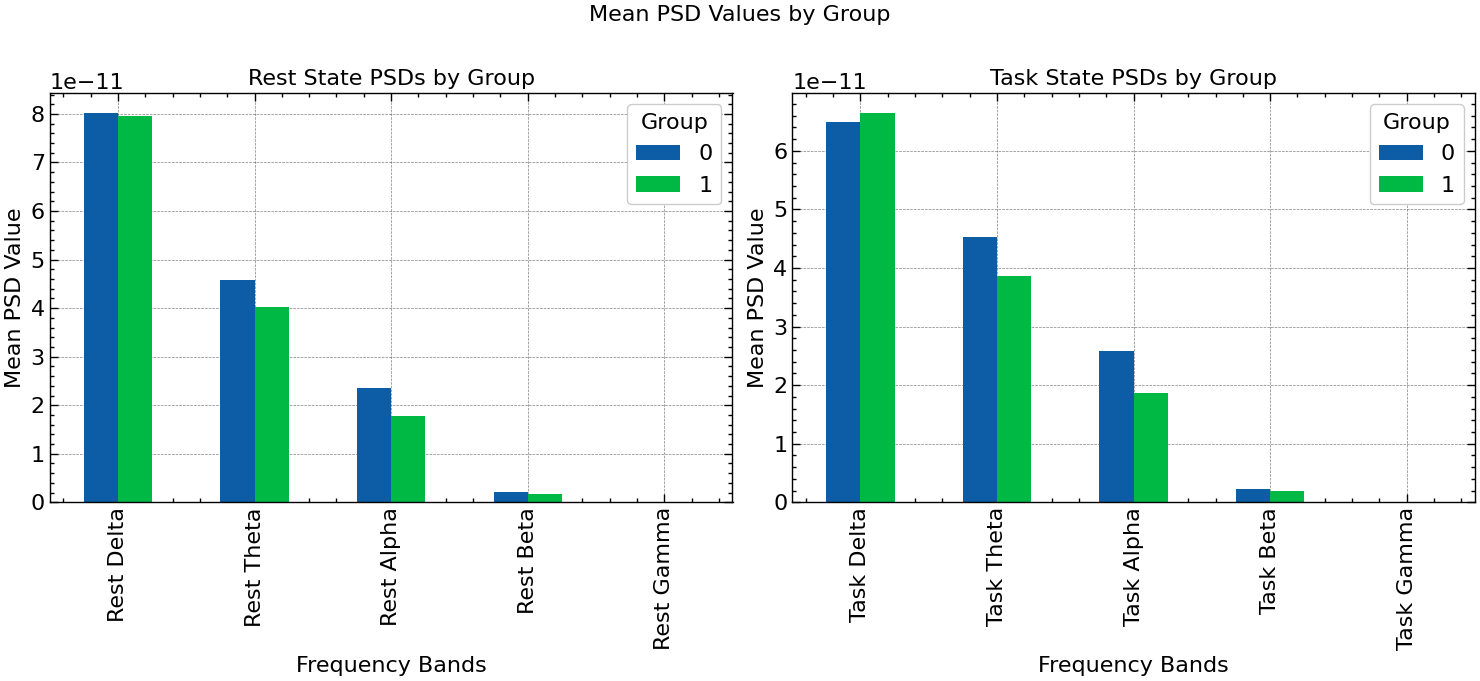

In [7]:
# Mean PSD values for each group
grouped_psd = psd_results.groupby('Group').mean(numeric_only=True)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('Mean PSD Values by Group', fontsize=16)

grouped_psd[rest_psd_cols].transpose().plot(kind='bar', ax=axes[0])
axes[0].set_title('Rest State PSDs by Group')
axes[0].set_xlabel('Frequency Bands')
axes[0].set_ylabel('Mean PSD Value')

grouped_psd[task_psd_cols].transpose().plot(kind='bar', ax=axes[1])
axes[1].set_title('Task State PSDs by Group')
axes[1].set_xlabel('Frequency Bands')
axes[1].set_ylabel('Mean PSD Value')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

**Key Comparison Insights**

- In both rest and task states, Group 0 generally exhibits higher mean PSD values across most frequency bands, indicating potentially higher brain activity in these bands.
- The differences are more pronounced in the Alpha, Beta, and Gamma bands during the resting state.
- For the task state, while Group 0 generally shows higher mean PSD values, Group 1 surpasses Group 0 slightly in the Delta and Gamma bands.
- These variations suggest that the two groups may have distinct patterns of brain activity during both resting and task conditions.

### Step 2.2.4. Inferential Statistics

We perform t-tests to determine if there are significant differences in PSD values between rest and task states for each frequency band.

In [8]:
# T-tests
ttest_results = {}
for rest_col, task_col in zip(rest_psd_cols, task_psd_cols):
    t_stat, p_val = ttest_rel(psd_results[rest_col], psd_results[task_col])
    ttest_results[f'{rest_col} vs {task_col}'] = (t_stat, p_val)

ttest_results

{'Rest Delta vs Task Delta': (2.2909764039517193, 0.028100637180407898),
 'Rest Theta vs Task Theta': (0.6778537678783968, 0.5023213160710958),
 'Rest Alpha vs Task Alpha': (-0.9202826993596477, 0.36372481837045734),
 'Rest Beta vs Task Beta': (-1.4844412213952136, 0.14664307500169402),
 'Rest Gamma vs Task Gamma': (-3.1220240640909904, 0.0035921788170816416)}

**Key Insights:**

- Delta Band: There is a statistically significant difference in PSD values between rest and task states (p=0.028p=0.028). This suggests that brain activity in the Delta band changes notably when transitioning from a resting state to a task state.

- Theta Band: No significant difference in PSD values between rest and task states (p=0.502). This indicates that brain activity in the Theta band remains relatively stable across these states.

- Alpha Band: No significant difference in PSD values between rest and task states (p=0.364). Brain activity in the Alpha band does not show substantial changes between resting and task conditions.

- Beta Band: No significant difference in PSD values between rest and task states (p=0.147). The Beta band activity remains relatively unchanged between rest and task states.

- Gamma Band: There is a statistically significant difference in PSD values between rest and task states (p=0.004). This indicates a notable change in Gamma band activity when moving from rest to a task state.

Overall, significant differences were found in the Delta and Gamma bands between rest and task states, suggesting that these frequency bands are more sensitive to changes in brain activity due to task engagement. Other bands (Theta, Alpha, and Beta) did not show significant differences, indicating more stability in their activity across different states

### Step 2.2.5. Correlation Analysis

We analyze the correlation between PSD values and other variables like age, gender, and number of subtractions.

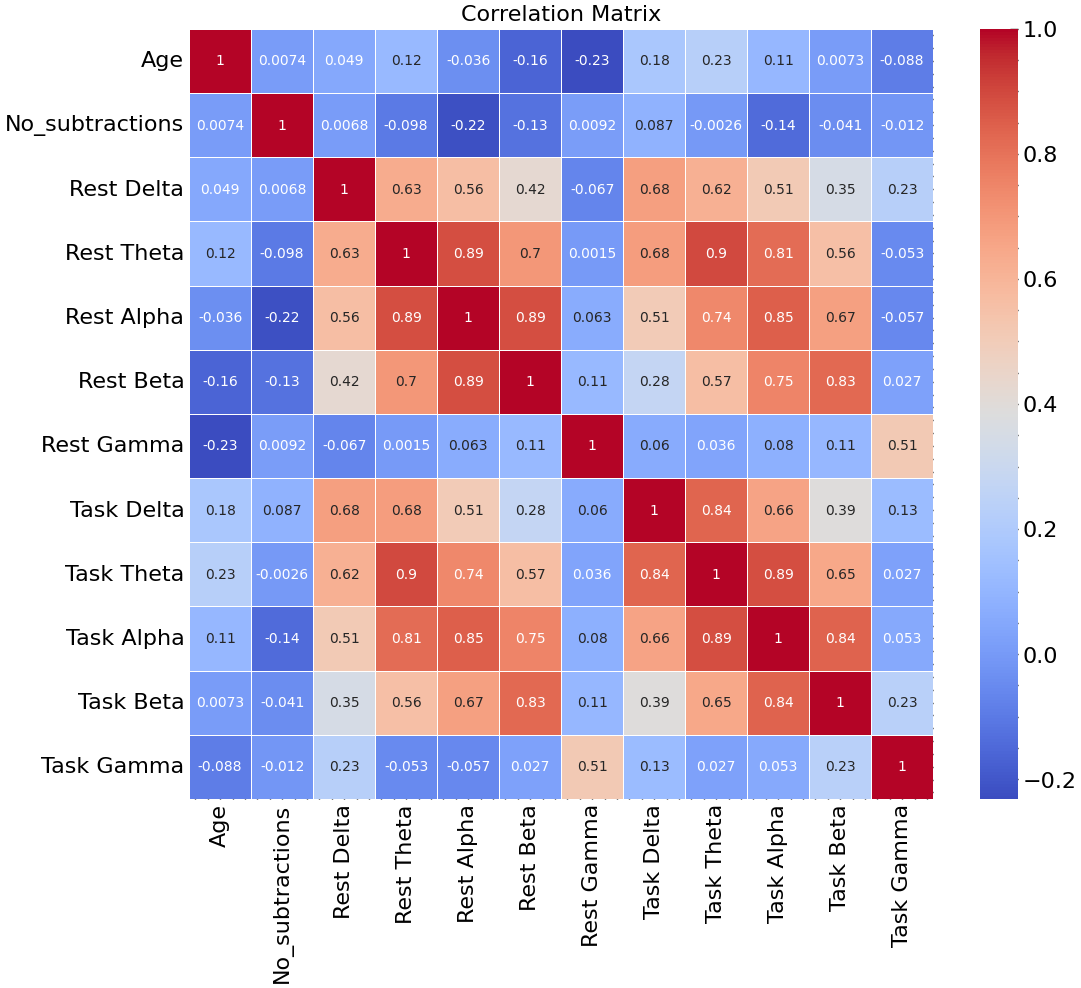

In [9]:
# Correlation matrix
correlation_matrix = psd_results[['Age', 'No_subtractions'] + rest_psd_cols + task_psd_cols].corr()

# Plotting
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

**Key Insights:**
- Rest state PSDs show stronger inter-correlations, particularly between Delta, Theta, and Alpha bands, suggesting more synchronized activity during rest.
- Task state PSDs exhibit moderate inter-correlations, with Delta and Theta bands showing notable relationships, indicating changes in brain activity patterns during tasks.
- Gamma band in both states shows lower correlations with other bands, highlighting its distinct role in brain activity.
- Age and No_subtractions have minimal impact on PSD values, suggesting other factors may play more significant roles in influencing brain activity

### Step 2.2.6 Comparative Analysis Across Gender and Age

We calculate the summary statistics for the PSD values across different frequency bands for both rest and task states, grouped by gender.

In [10]:
# Summary statistics by gender
gender_rest_summary = psd_results.groupby('Gender')[rest_psd_cols].describe()
gender_task_summary = psd_results.groupby('Gender')[task_psd_cols].describe()

gender_rest_summary, gender_task_summary

(       Rest Delta                                                          \
             count          mean           std           min           25%   
 Gender                                                                      
 F            27.0  8.411863e-11  5.007452e-11  1.277914e-11  5.238248e-11   
 M             9.0  6.687482e-11  4.476101e-11  6.797017e-12  4.937301e-11   
 
                                                  Rest Theta                \
                  50%           75%           max      count          mean   
 Gender                                                                      
 F       7.318994e-11  1.062254e-10  2.667323e-10       27.0  4.222164e-11   
 M       5.723604e-11  8.280631e-11  1.585902e-10        9.0  4.067212e-11   
 
         ...     Rest Beta               Rest Gamma                \
         ...           75%           max      count          mean   
 Gender  ...                                                        
 F       

**Key Findings:**
- Rest State: Females generally exhibit higher mean PSD values and greater variability across all frequency bands compared to males. This suggests that during rest, females may have higher brain activity levels and more variability in their brain activity.

- Task State: Differences between genders are less pronounced in the task state. Both genders show similar mean PSD values, with females slightly higher in Alpha and Gamma bands, and males slightly higher in Theta band. Variability is generally higher for females, indicating more diverse brain activity patterns during tasks.

Overall, gender appears to influence PSD values, with females showing higher mean values and variability, especially during the resting state

We create age groups and calculate summary statistics for the PSD values.

In [11]:
# Create age groups
psd_results['Age Group'] = pd.cut(psd_results['Age'], bins=[16, 18, 20, 23, 36], labels=['16-18', '19-20', '21-23', '24-26'])


# Summary statistics by age group
age_rest_summary = psd_results.groupby('Age Group')[rest_psd_cols].describe()
age_task_summary = psd_results.groupby('Age Group')[task_psd_cols].describe()


age_rest_summary, age_task_summary

(          Rest Delta                                                          \
                count          mean           std           min           25%   
 Age Group                                                                      
 16-18           21.0  7.974628e-11  5.285204e-11  2.035481e-11  5.177369e-11   
 19-20            8.0  7.391560e-11  3.441396e-11  1.277914e-11  6.189356e-11   
 21-23            2.0  8.708757e-11  5.107299e-11  5.097351e-11  6.903054e-11   
 24-26            2.0  8.269363e-11  1.073340e-10  6.797017e-12  4.474532e-11   
 
                                                     Rest Theta                \
                     50%           75%           max      count          mean   
 Age Group                                                                      
 16-18      6.389266e-11  8.684069e-11  2.667323e-10       21.0  3.681755e-11   
 19-20      7.799813e-11  9.202979e-11  1.260619e-10        8.0  4.199847e-11   
 21-23      8.708757e-11  

**Key Findings:**
- Rest State:

  - Younger age groups (16-18) tend to have higher mean PSD values in the Delta, Theta, and Gamma bands.
  - Variability is higher in younger age groups for most frequency bands.
  - The 24-26 age group shows the highest variability in Beta and Gamma bands.

- Task State:

  - Older age groups (21-26) generally show higher mean PSD values in Delta, Theta, and Alpha bands.
  - Variability in task state PSD values is more pronounced in the younger age groups (16-20).
  - The 24-26 age group shows notably high mean PSD values and variability in the Delta band.

#### Step 2.2.7 Inferential Statistics by Gender

We perform t-tests to determine if there are significant differences in PSD values between genders.

In [15]:
# T-tests by gender
gender_ttest_results = {}
for col in rest_psd_cols + task_psd_cols:
    male_psd = psd_results[psd_results['Gender'] == 'M'][col]
    female_psd = psd_results[psd_results['Gender'] == 'F'][col]
    t_stat, p_val = ttest_ind(male_psd, female_psd)
    gender_ttest_results[col] = (t_stat, p_val)

gender_ttest_results = pd.DataFrame(gender_ttest_results).T
gender_ttest_results.columns = ['T-Statistic', 'P-Value']
gender_ttest_results

,T-Statistic,P-Value
Rest Delta,-0.916615,0.365801
Rest Theta,-0.170069,0.865964
Rest Alpha,-0.226411,0.822238
Rest Beta,0.138590,0.890592
Rest Gamma,-0.493946,0.624520
Task Delta,-0.004644,0.996322
Task Theta,0.228850,0.820356
Task Alpha,0.264629,0.792893
Task Beta,0.766441,0.448703
Task Gamma,-0.806084,0.425797


**Key Insights:**
- Across both rest and task states, there are no significant differences in PSD values between males and females in any of the frequency bands.
- The p-values for all tests are well above the typical significance level of 0.05, indicating that gender does not significantly affect PSD values in this dataset.

### Step 2.2.8 Inferential Statistics by Age Group

We perform Kruskal-Wallis Test by Age Group

The Kruskal-Wallis test is a non-parametric alternative to ANOVA. We do this as ANOVA assumes normality and homogeneity of variance, which may not be met in this case and ANOVA gives NaN values for some bands due to insufficient data in one or more groups. This suggests that the dataset may not have enough subjects across the different age groups to perform a robust analysis.

In [13]:
# Kruskal-Wallis test by age group
age_kruskal_results = {}
for col in rest_psd_cols + task_psd_cols:
    groups = [group[col].values for name, group in psd_results.groupby('Age Group') if not group[col].isnull().all()]
    if len(groups) > 1:  # Ensure there are at least two groups with data
        h_stat, p_val = kruskal(*groups)
        age_kruskal_results[col] = (h_stat, p_val)
    else:
        age_kruskal_results[col] = (np.nan, np.nan)

age_kruskal_results = pd.DataFrame(age_kruskal_results).T
age_kruskal_results.columns = ['H-Statistic', 'P-Value']
age_kruskal_results

,H-Statistic,P-Value
Rest Delta,0.160237,0.983738
Rest Theta,1.046155,0.790086
Rest Alpha,0.034123,0.998341
Rest Beta,0.795073,0.850645
Rest Gamma,2.882926,0.410030
Task Delta,0.723771,0.867599
Task Theta,2.337471,0.505380
Task Alpha,2.035714,0.565027
Task Beta,3.333843,0.342960
Task Gamma,4.055322,0.255552


- Across both rest and task states, there are no significant differences in PSD values across age groups in any of the frequency bands.
- The p-values for all tests are well above the typical significance level of 0.05, indicating that age groups do not significantly affect PSD values in this dataset.

### Step 2.2.9 We perform Pairwise Mann-Whitney U Tests for Age Groups

The Mann-Whitney U test can be used for pairwise comparisons between age groups.

In [14]:
# Perform Mann-Whitney U tests by age group
age_groups = psd_results['Age Group'].dropna().unique()
pairwise_results = []

for col in rest_psd_cols + task_psd_cols:
    for i in range(len(age_groups)):
        for j in range(i + 1, len(age_groups)):
            group1 = psd_results[psd_results['Age Group'] == age_groups[i]][col].dropna()
            group2 = psd_results[psd_results['Age Group'] == age_groups[j]][col].dropna()
            if len(group1) > 0 and len(group2) > 0:
                u_stat, p_val = mannwhitneyu(group1, group2)
                pairwise_results.append({
                    'Frequency Band': col,
                    'Comparison': f'{age_groups[i]} vs {age_groups[j]}',
                    'U-statistic': u_stat,
                    'p-value': p_val
                })

pairwise_results_df = pd.DataFrame(pairwise_results)
pairwise_results_df.head()

,Frequency Band,Comparison,U-statistic,p-value
0,Rest Delta,21-23 vs 16-18,23.0,0.869565
1,Rest Delta,21-23 vs 19-20,9.0,0.888889
2,Rest Delta,21-23 vs 24-26,2.0,1.000000
3,Rest Delta,16-18 vs 19-20,76.0,0.719902
4,Rest Delta,16-18 vs 24-26,22.0,0.956522


**Key Insights:**
- Across both rest and task states, there are no significant differences in PSD values across most age groups in any of the frequency bands.
- Task Gamma shows a significant difference between the 19-20 and 24-26 age groups with a p-value of 0.044.
- The p-values for other tests are well above the typical significance level of 0.05, indicating that age groups generally do not significantly affect PSD values in this dataset.

### Step 2.2.10 Plotting Mean PSD Values by Gender

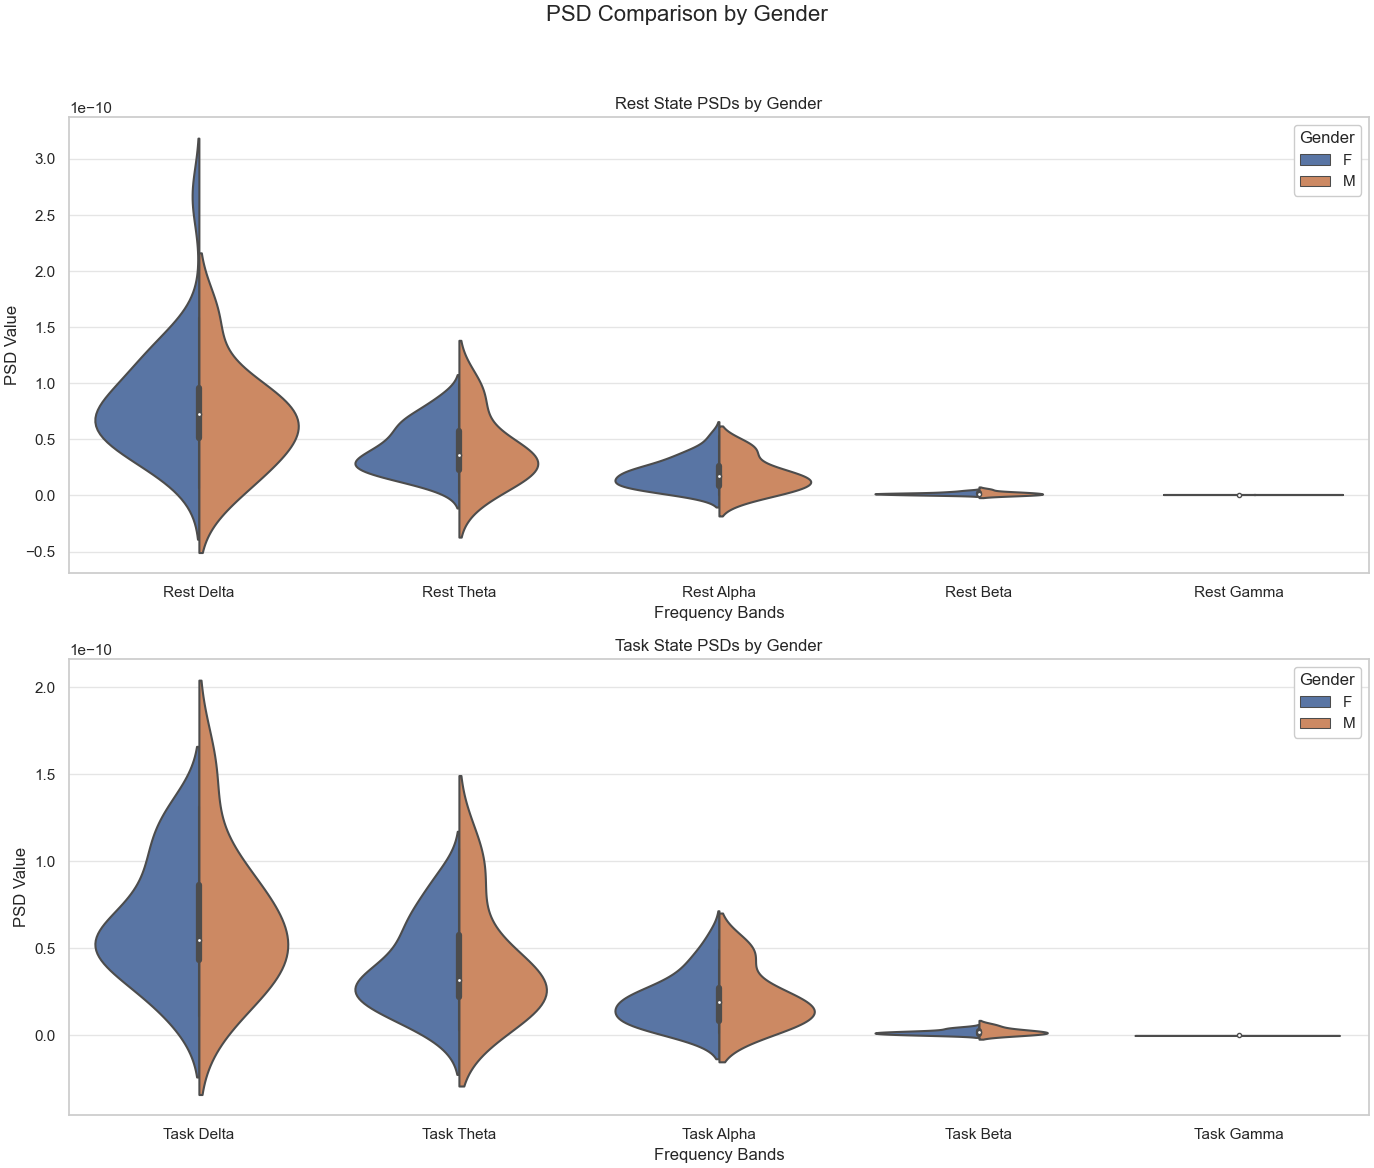

In [16]:
# Setting the style for the plots
sns.set(style="whitegrid")

# Function to create comparison plots for gender
def plot_gender_comparison(data, rest_cols, task_cols):
    fig, axes = plt.subplots(2, 1, figsize=(14, 12))
    fig.suptitle('PSD Comparison by Gender', fontsize=16)

    # Melt the data for easier plotting
    rest_melted = data.melt(id_vars=['Gender'], value_vars=rest_cols, var_name='Band', value_name='PSD')
    task_melted = data.melt(id_vars=['Gender'], value_vars=task_cols, var_name='Band', value_name='PSD')

    # Rest State
    sns.violinplot(x='Band', y='PSD', hue='Gender', data=rest_melted, split=True, ax=axes[0])
    axes[0].set_title('Rest State PSDs by Gender')
    axes[0].set_xlabel('Frequency Bands')
    axes[0].set_ylabel('PSD Value')

    # Task State
    sns.violinplot(x='Band', y='PSD', hue='Gender', data=task_melted, split=True, ax=axes[1])
    axes[1].set_title('Task State PSDs by Gender')
    axes[1].set_xlabel('Frequency Bands')
    axes[1].set_ylabel('PSD Value')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Plotting gender comparison
plot_gender_comparison(psd_results, rest_psd_cols, task_psd_cols)


**Key Insights**
- Rest State: Across all frequency bands, there are no significant differences in PSD values between males and females. Both genders exhibit similar distributions, suggesting that resting state brain activity is comparable across genders.
- Task State: Similar to the rest state, task state PSD values show no significant gender differences across all frequency bands. The distributions are largely overlapping, indicating comparable brain activity during tasks for both males and females

### Step 2.2.11 Plotting Mean PSD Values by Age Group

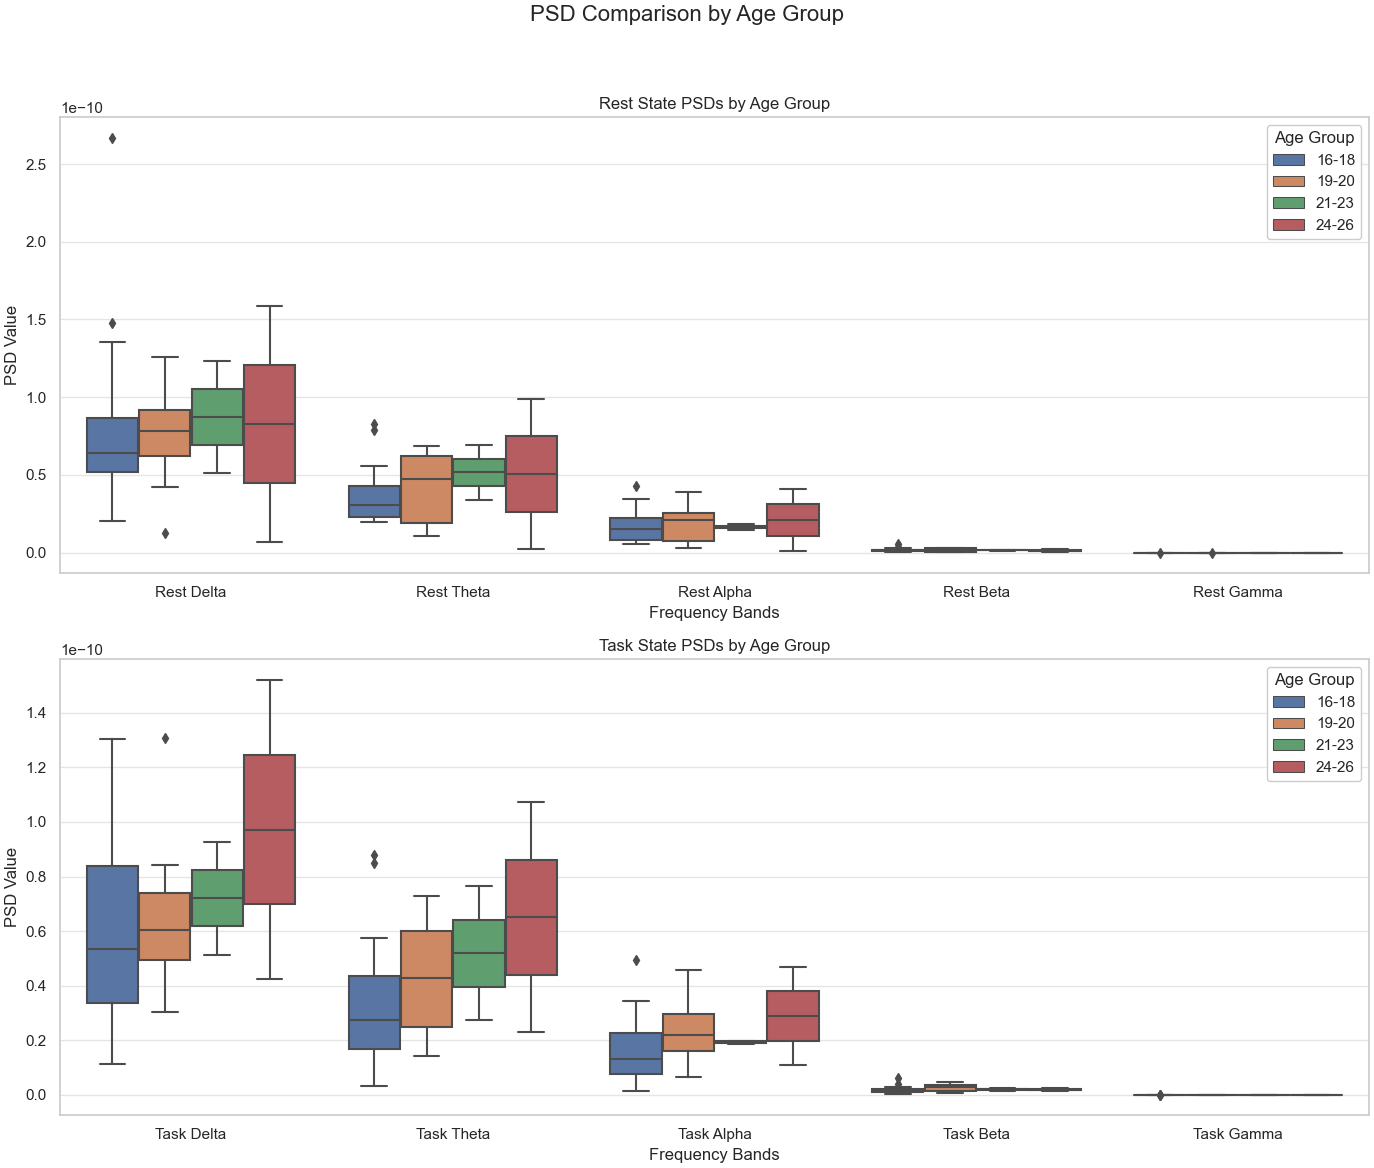

In [17]:
# Function to create comparison plots for age group
def plot_age_group_comparison(data, rest_cols, task_cols):
    fig, axes = plt.subplots(2, 1, figsize=(14, 12))
    fig.suptitle('PSD Comparison by Age Group', fontsize=16)

    # Melt the data for easier plotting
    rest_melted = data.melt(id_vars=['Age Group'], value_vars=rest_cols, var_name='Band', value_name='PSD')
    task_melted = data.melt(id_vars=['Age Group'], value_vars=task_cols, var_name='Band', value_name='PSD')

    # Rest State
    sns.boxplot(x='Band', y='PSD', hue='Age Group', data=rest_melted, ax=axes[0])
    axes[0].set_title('Rest State PSDs by Age Group')
    axes[0].set_xlabel('Frequency Bands')
    axes[0].set_ylabel('PSD Value')

    # Task State
    sns.boxplot(x='Band', y='PSD', hue='Age Group', data=task_melted, ax=axes[1])
    axes[1].set_title('Task State PSDs by Age Group')
    axes[1].set_xlabel('Frequency Bands')
    axes[1].set_ylabel('PSD Value')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Plotting age group comparison
plot_age_group_comparison(psd_results, rest_psd_cols, task_psd_cols)

**Key Insights**
- Rest State:
    - Age groups show similar PSD value distributions with slight variations in median values across different frequency bands.
    - No significant differences in overall distributions, indicating comparable resting state brain activity across age groups.

- Task State:
    - Similar to the rest state, task state PSD values show consistent distributions across age groups.
    - Minor variations in medians are present in some frequency bands, but overall, brain activity during tasks is comparable across different age groups.

This suggests that while there are slight variations in median PSD values across age groups, the overall distributions indicate similar brain activity patterns during both resting and task states.

## Step 2.3: Summary of Key Findings
---

- **Gender Comparison:**
  - Resting state:
    - No significant differences in PSD values between males and females.
    - P-values: Delta (0.366), Theta (0.866), Alpha (0.822), Beta (0.891), Gamma (0.625).
  - Task state:
    - No significant differences in PSD values between males and females.
    - P-values: Delta (0.996), Theta (0.820), Alpha (0.793), Beta (0.449), Gamma (0.426).

- **Age Group Comparison:**
  - Kruskal-Wallis Test:
    - No significant differences in PSD values across age groups.
    - P-values: Rest Delta (0.984), Rest Theta (0.790), Rest Alpha (0.998), Rest Beta (0.851), Rest Gamma (0.410), Task Delta (0.868), Task Theta (0.505), Task Alpha (0.565), Task Beta (0.343), Task Gamma (0.256).
  - Mann-Whitney U Test:
    - No significant differences in PSD values in most frequency bands across age groups.
    - Significant difference only in Task Gamma between 19-20 and 24-26 age groups (p-value: 0.044).

- **Rest State Comparison by Gender:**
  - Delta, Theta, Alpha, Beta, Gamma bands show similar distributions across genders.
  - Females exhibit slightly higher variability in Gamma band.

- **Task State Comparison by Gender:**
  - Similar distributions across genders in all frequency bands.
  - No significant gender differences observed in any frequency band.

- **Rest State Comparison by Age Group:**
  - Delta and Theta bands: Slightly higher median values in 21-23 and 24-26 age groups.
  - Alpha band: Higher median value in 21-23 age group.
  - Beta and Gamma bands: Similar distributions across all age groups.

- **Task State Comparison by Age Group:**
  - Delta and Theta bands: Higher median values in 24-26 age group.
  - Alpha band: Higher median value in 21-23 age group.
  - Beta and Gamma bands: Similar distributions across all age groups.
  - Significant p-value in Task Gamma (19-20 vs. 24-26): 0.044.
    - All other p-values in gender and age group comparisons are above the 0.05 significance threshold, indicating no significant differences.  

### Probable Reasons
- Brain activity, as measured by PSD values, appears consistent across genders, suggesting no significant differences in neural oscillations due to gender.
- Age-related variations are minimal, likely due to the small age range in the dataset, indicating similar neural oscillatory patterns among young adults.
- Task and rest states show comparable distributions in PSD values, highlighting stable brain activity patterns regardless of the state.

# Step 3: Modelling
---

## Step 3.1: Dataset preparation
We have the data of the signals from the EDF files. Also, we have the PSD results from out analysis. We will try to combine these two datasets to create a single dataset for modelling.

Steps for dataset preparation:
- Load signals for each subject.
- Combine the signals with the PSD results.
- One-Hot Encode the categorical variables.
- Split dataset into training and testing sets and validation sets.
We use a 80-20 split for training and testing sets and a 80-20 split on the training set for training and validation sets.
- Min-Max scaling of the features. This is done after the split to avoid data leakage. We choose min-max scaling as we are not assuming Normal distribution of all features.
- Augment the data with various data augmentation techniques for EEG data as we have very less number of samples and hence, we are prone to overfitting.
- Fill `NaN` values with 0 which may occur due to the min-max scaling.

#### Step 3.1.1: Loading and normalizing signals
We create a function to load the signals and normalize their lengths for each subject.

In [18]:
def load_and_normalize_edf_signal(file_path, target_length=None):
    """
    Load EDF signal data from the given file path and normalize the length.

    Args:
    - file_path (str): Path to the EDF file.
    - target_length (int, optional): Target length to pad/truncate signals to.

    Returns:
    - signals (np.array): 2D array of normalized signals.
    """
    _, signals = read_edf(file_path)

    # Normalize length
    if target_length is not None:
        signals = [np.pad(signal, (0, max(0, target_length - len(signal))), 'constant')[:target_length] for signal in signals]

    return np.array(signals)

def min_max_scale_columns(data: np.ndarray) -> np.ndarray:
    """
    Apply Min-Max scaling only to the columns whose values are not just 1s and 0s.

    Parameters:
    data (np.ndarray): The input data array.

    Returns:
    np.ndarray: The scaled data array.
    """
    # Copy the data to avoid modifying the original array
    scaled_data = np.copy(data)

    # Identify columns to scale
    for i in range(scaled_data.shape[2]):
        # Check if the column contains only 1s and 0s
        unique_values = np.unique(scaled_data[:, :, i])
        if len(unique_values) > 2 or (len(unique_values) == 2 and not set(unique_values).issubset({0, 1})):
            # Vectorized Min-Max scaling
            col_min = np.min(scaled_data[:, :, i], axis=(0, 1), keepdims=True)
            col_max = np.max(scaled_data[:, :, i], axis=(0, 1), keepdims=True)
            scaled_data[:, :, i] = (scaled_data[:, :, i] - col_min) / (col_max - col_min)

    return scaled_data

In [19]:
def get_processed_data(psd_results, base_path, target_length=91000, test_size: float = 0.2, val_size: float = 0.2):
    """
    Process all subjects, calculate PSD for rest and task states, and store the results.

    Args:
    - subject_info (pd.DataFrame): DataFrame containing subject information.
    - base_path (str): Base path where the EDF files are stored.
    - target_length (int, optional): Target length to pad/truncate signals to.
    - test_size (float, optional): Fraction of the data to be used for testing.

    Returns:
    - np.array: Training features, training labels, testing features, testing labels, validation features, validation labels
    """
    rest_file_paths = [f"{base_path}/{subject_id}_1.edf" for subject_id in psd_results['Subject ID']]
    task_file_paths = [f"{base_path}/{subject_id}_2.edf" for subject_id in psd_results['Subject ID']]

    # Get the rest and task signals for all subjects
    X_rest = np.array([load_and_normalize_edf_signal(file_path, target_length=target_length) for file_path in rest_file_paths])
    X_task = np.array([load_and_normalize_edf_signal(file_path, target_length=target_length) for file_path in task_file_paths])

    # Add a colum in X_rest to mark it as rest signal
    X_rest = np.concatenate([X_rest, np.zeros((X_rest.shape[0], X_rest.shape[1], 1))], axis=2)
    # Add a colum in X_task to mark it as task signal
    X_task = np.concatenate([X_task, np.ones((X_task.shape[0], X_task.shape[1], 1))], axis=2)

    y = psd_results['Group'].values

    commmon_cols = ['Age', 'Gender', 'Recording_year', 'No_subtractions', 'Count_quality']
    rest_cols = commmon_cols + ['Rest Delta', 'Rest Theta', 'Rest Alpha', 'Rest Beta', 'Rest Gamma']
    task_cols = commmon_cols + ['Task Delta', 'Task Theta', 'Task Alpha', 'Task Beta', 'Task Gamma']

    X_psd_rest = psd_results[rest_cols]
    X_psd_task = psd_results[task_cols]

    # one-Hot encode the Gender column 
    X_psd_rest = pd.get_dummies(X_psd_rest, columns=['Gender'], drop_first=True, dtype=np.float32).values
    X_psd_task = pd.get_dummies(X_psd_task, columns=['Gender'], drop_first=True, dtype=np.float32).values

    # Make the PSD features 3D
    X_psd_rest = np.repeat(X_psd_rest[:, np.newaxis, :], X_rest.shape[1], axis = 1)
    X_psd_task = np.repeat(X_psd_task[:, np.newaxis, :], X_task.shape[1], axis = 1)

    # Combine the PSD features with the signal data
    X_rest = np.concatenate([X_psd_rest, X_rest], axis=2)
    X_task = np.concatenate([X_psd_task, X_task], axis=2)

    X_combined = np.concatenate([X_rest, X_task], axis = 0)

    y = np.concatenate([y, y], axis = 0) # Duplicate the labels for the task signals

    # Split the training data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=test_size, random_state=42)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=val_size, random_state=42)
    X_train = min_max_scale_columns(X_train)
    X_test = min_max_scale_columns(X_test)

    return X_train, y_train, X_test, y_test, X_valid, y_valid

# Get the processed data
X_train, y_train, X_test, y_test, X_valid, y_valid = get_processed_data(psd_results, base_path, target_length=91000)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"X_valid shape: {X_valid.shape}, y_valid shape: {y_valid.shape}")
print(f"Number of unique classes: {np.unique(y_train).size}")

X_train shape: (45, 21, 91011), y_train shape: (45,)
X_test shape: (15, 21, 91011), y_test shape: (15,)
X_valid shape: (12, 21, 91011), y_valid shape: (12,)
Number of unique classes: 2


## Step 3.1.2: Data Augmentation
As the number of samples in our data are very small, we will augment our dataset to prevent overfitting and improve generalisation. Here are the techniques we will use:

### Data Augmentation Techniques for EEG Data

#### 1. Gaussian Noise
- **Description:** Adds Gaussian white noise to the EEG signals.
- **Mathematics:** $\tilde{x}(t) = x(t) + \epsilon(t)$, where $\epsilon(t) \sim \mathcal{N}(0, \sigma^2)$.
- **Purpose:** Makes the model more robust to noise in EEG recordings.

#### 2. Smooth Time Mask
- **Description:** Replaces a portion of the signal with zeros, starting from a randomly sampled instant.
- **Mathematics:** $\tilde{x}(t) = 0$ for $t \in [t_0, t_0 + \Delta t]$.
- **Purpose:** Encourages the model to capture global signal information rather than isolated transient events.

#### 3. Time Reverse
- **Description:** Randomly flips the time axis of all channels.
- **Mathematics:** $\tilde{x}(t) = x(T - t)$, where $T$ is the total duration.
- **Purpose:** Preserves frequency power ratios while altering time-domain representations.

#### 4. Sign Flip
- **Description:** Randomly inverts the sign of all EEG channels.
- **Mathematics:** $\tilde{x}(t) = -x(t)$.
- **Purpose:** Preserves topographical properties of the electric field potential while changing its polarity.

#### 5. Frequency Shift
- **Description:** Shifts the spectrum of the EEG signals by a random frequency.
- **Mathematics:** $\tilde{X}(f) = X(f + \Delta f)$, where $X(f)$ is the Fourier transform of $x(t)$ and $\Delta f$ is a small random shift.
- **Purpose:** Mimics inter-subject variability by altering the location of frequency peaks.


### Applying Augmentations to the Dataset with Labels

For each augmentation technique, the labels of the augmented data remain the same as the original data to maintain consistency.

### Break the data into chunks
After that, we break the dat ainto chunks so that we can augment the data and our model may generalise. Breaking into chunks means we break each signal into "chunks" (of size 2000 each) for further classification.

In [20]:
def add_gaussian_noise(data, sigma=0.1):
    noise = sigma * np.random.randn(*data.shape)
    return data + noise


def smooth_time_mask(data, delta_t=1000):
    augmented_data = data.copy()
    t0 = np.random.randint(0, data.shape[2] - delta_t)
    augmented_data[:, :, t0:t0 + delta_t] = 0
    return augmented_data


def time_reverse(data):
    return np.flip(data, axis=2)


def sign_flip(data):
    return -data


def augment_data(data, labels):
    augmented_data = data
    augmented_labels = labels

    # Define augmentation functions and their parameters
    augmentations = [
        (add_gaussian_noise, {'sigma': 0.12}),
        (smooth_time_mask, {'delta_t': 1000}),
        (time_reverse, {}),
        (sign_flip, {})]

    # Apply each augmentation function to the dataset
    for func, params in augmentations:
        augmented = func(data, **params)
        augmented_data = np.concatenate([augmented_data, augmented], axis=0)
        augmented_labels = np.concatenate([augmented_labels, labels], axis=0)

    return augmented_data, augmented_labels


def preprocess_into_chunks(X, y, chunk_size = 2000):
  # Choose a chunk size
  chunks_per_sample = X.shape[2] // chunk_size

  # Reshape X to match expected input shape for Braindecode
  X = X[:, :, :chunks_per_sample * chunk_size].reshape(-1, 21, chunk_size)
  y = np.repeat(y, chunks_per_sample)

  print("Data shape:", X.shape)  # (n_chunks, n_channels, chunk_size)

  return X, y


X_train, y_train = augment_data(X_train, y_train)

CHUNK_SIZE = 2000
X_train, y_train = preprocess_into_chunks(X_train, y_train, chunk_size=CHUNK_SIZE)
X_valid, y_valid = preprocess_into_chunks(X_valid, y_valid, chunk_size=CHUNK_SIZE)
X_test, y_test = preprocess_into_chunks(X_test, y_test, chunk_size=CHUNK_SIZE)

Data shape: (10125, 21, 2000)
Data shape: (540, 21, 2000)
Data shape: (675, 21, 2000)


### Step 3.1.3: Convert into data loaders

In [21]:
def create_data_loader(data: np.ndarray, targets: np.ndarray, batch_size: int = 8, shuffle: bool = True, reshape = False) -> DataLoader:
    """
    Create a DataLoader from the given numpy array and targets.

    Parameters:
    data (np.ndarray): Preprocessed data array of shape (num_samples, num_channels, time_points).
    targets (np.ndarray): Targets array of shape (num_samples,).
    batch_size (int): The batch size for the DataLoader.
    shuffle (bool): Whether to shuffle the data.

    Returns:
    DataLoader: A DataLoader for the given data and targets.
    """
    # Ensure data has the correct shape: (num_samples, num_channels, time_points)
    assert len(data.shape) == 3, "Data must have 3 dimensions: (num_samples, num_channels, time_points)"
    assert len(targets.shape) == 1, "Targets must have 1 dimension: (num_samples,)"
    assert data.shape[0] == targets.shape[0], "Data and targets must have the same number of samples"

    # Reshape to (num_samples, 1, num_channels, time_points)
    if reshape:
        data = data.reshape(data.shape[0], 1, data.shape[1], data.shape[2])

    # Convert the data and targets to PyTorch tensors
    data_tensor = torch.tensor(data, dtype=torch.float32)
    targets_tensor = torch.tensor(targets, dtype=torch.long)

    # Create a TensorDataset
    dataset = TensorDataset(data_tensor, targets_tensor)

    # Create a DataLoader
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    return data_loader

# Create DataLoaders for training and testing data
BATCH_SIZE = 8
train_loader = create_data_loader(X_train, y_train, batch_size=8, shuffle=True, reshape=True)
val_loader = create_data_loader(X_valid, y_valid, batch_size=8, shuffle=False, reshape=True)
test_loader = create_data_loader(X_test, y_test, batch_size=8, shuffle=False, reshape=True)

print(f"Training shape = {next(iter(train_loader))[0].shape}")
print(f"Validation shape = {next(iter(val_loader))[0].shape}")
print(f"Testing shape = {next(iter(test_loader))[0].shape}")

Training shape = torch.Size([8, 1, 21, 2000])
Validation shape = torch.Size([8, 1, 21, 2000])
Testing shape = torch.Size([8, 1, 21, 2000])


## Step 3.2: EEGNET: Raw Pytorch Implementation
---
source : EEGNet: A Compact Convolutional Neural Network for EEG-based Brain-Computer Interfaces (https://arxiv.org/abs/1611.08024)

C = Channel, T = Time, F1 = n of Temporal Filter, D = Depth (n of spatial filter), F2 = n of pointwise filter

- Input (C x T)
- Reshape (1, C, T)
- Conv2D (F1, C, T)
- BatchNorm2D (F1, C, T)
- DepthwiseConv2D (D * F1, 1, T)
- BatchNorm (D * F1, 1, T)
- Activation (D * F1, 1, T) - ELU
- AveragePool2D (D * F1, 1, T // 4) - (1,4) pool
- DropOut (D * F1, 1, T // 4)
- SeparableConv2D (F2 1, T // 4)
- BatchNorm (F2 1, T // 4)
- Activation (F2 1, T // 4) - ELU
- AveragePool2D (F2 1, T // 32) - (1,8) pool
- DropOut (F2 1, T // 32)
- Flatten (F2 * (T // 32))
- Dense (N) - SoftMax

WE use xavier initialisation to decrease covariance shift and improve genralisation.

In [22]:
class EEGNet(nn.Module):
    def __init__(self, num_classes=4, channels=22, samples=256, dropout_prob=0.5):
        super(EEGNet, self).__init__()

        self.F1 = 8
        self.F2 = 16
        self.D = 2
        self.dropout_prob = dropout_prob

        # Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias)
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, self.F1, (1, 64), padding=(0, 32), bias=False),
            nn.BatchNorm2d(self.F1),
            nn.Dropout(self.dropout_prob * 0.5)  # Dropout after the first conv layer
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(self.F1, self.D * self.F1, (channels, 1), groups=self.F1, bias=False),
            nn.BatchNorm2d(self.D * self.F1),
            nn.ELU(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(self.dropout_prob)  # Dropout after the second conv layer
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(self.D * self.F1, self.D * self.F1, (1, 16), padding=(0, 8), groups=self.D * self.F1, bias=False),
            nn.Conv2d(self.D * self.F1, self.F2, (1, 1), bias=False),
            nn.BatchNorm2d(self.F2),
            nn.ELU(),
            nn.AvgPool2d((1, 8)),
            nn.Dropout(self.dropout_prob)  # Dropout after the third conv layer
        )

        # Calculate the output size after convolutions
        self.classifier = nn.Sequential(
            nn.Linear(self.F2 * (samples // 32), num_classes, bias=True)
        )

        self._initialize_weights()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        x = x.view(x.size(0), -1)  # Flatten the output for the classifier
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        """Xavier initialization for the weights"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

### Training the Model
- We will use an Early Stopping callback to save the best model based on the validation loss.
- We will use the Adam optimizer with a learning rate of 0.001.
- We will use the Cross Entropy Loss for the binary classification task.
- We will log the training and validaion metrics during training
- We will save the best model weights based on the validation loss.
- We will use Dropout(with prob = 0.5) and weight decay(L2 regularization) to prevent overfitting as much as possible.

In [23]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_weights = None
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_weights = model.state_dict()
            self.save_checkpoint(model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_weights = model.state_dict()
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        '''Saves model when validation score improves.'''
        torch.save(model.state_dict(), self.path)



def ensure_dir(directory):
    """ Ensure the directory exists, if not create it. This is to save the model checkpoints and logs."""
    if not os.path.exists(directory):
        os.makedirs(directory)



def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience, log_dir, device):
    """ Train the model and save the best model based on validation AUC.
    Args:
        - model: The model to train.
        - train_loader: DataLoader for training data.
        - val_loader: DataLoader for validation data.
        - criterion: Loss function.
        - optimizer: Optimizer for training.
        - num_epochs: Number of epochs to train.
        - patience: Patience for early stopping.
        - log_dir: Directory to save the logs and model checkpoints.
        - device: Device to train the model on.
    Returns:
        - model: Trained model.
        - train_losses: List of training losses.
        - val_losses: List of validation losses.
        - train_metrics: List of training metrics.
        - val_metrics: List of validation metrics."""

    ensure_dir(log_dir)
    early_stopping = EarlyStopping(patience=patience, verbose=True, path=os.path.join(log_dir, 'best_model.pth'))

    train_log_path = os.path.join(log_dir, 'train_log.log')
    with open(train_log_path, 'w') as log_file:
        log_file.write("Epoch,Train Loss,Val Loss,Time\n")

    train_losses, val_losses = [], []

    # Move model to the specified device
    model.to(device)

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        train_loss = 0
        train_preds = []
        train_labels = []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        val_preds, val_labels = [], []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        epoch_time = time.time() - start_time

        with open(train_log_path, 'a') as log_file:
            log_file.write(f"{epoch+1},{train_loss:.4f}, {val_loss:.4f},{epoch_time:.4f}\n")

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {train_loss:.4f} - "
              f"Val Loss: {val_loss:.4f} - "
              f"Time: {epoch_time:.4f}s")

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    model.load_state_dict(early_stopping.best_weights)
    return model, train_losses, val_losses

In [25]:
# Get the hyperparameters for the model
batch, _ = next(iter(train_loader))
BATCH_SIZE, _, NUM_CHANNELS, NUM_SAMPLES = batch.size()
NUM_CLASSES = len(np.unique(y_train))
NUM_EPOCHS: int = 200
LEARNING_RATE: float = 0.001
PATIENCE = 15
DROPOUT_PROB: float = 0.50
WEIGHT_DECAY: float = 1e-4

#  Initialize model, criterion, optimizer
eegnet = EEGNet(num_classes=NUM_CLASSES, channels=NUM_CHANNELS, samples=NUM_SAMPLES, dropout_prob=DROPOUT_PROB)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(eegnet.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
# UNCOMMENT TO TRAIN THE MODEL
# eegnet, train_losses, val_losses = train_model(eegnet, train_loader, val_loader, criterion,
#                                     optimizer, num_epochs=NUM_EPOCHS,
#                                     patience=PATIENCE, log_dir='logs/EEGNET', device=device)

In [26]:
state_dict = torch.load("logs/EEGNET/best_model.pth", map_location=device)
eegnet.load_state_dict(state_dict)

<All keys matched successfully>

### A Library !!
There is a library called "BRAINDECODE" (https://braindecode.org/stable/index.html) which has th eimplementations EEGNET and ATCNET. We will also use this library to train EEGNET and ATCNET.

We wil reshape the dataloaders to match the dimensions of the implementations in the library.

In [27]:
train_loader = create_data_loader(X_train, y_train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = create_data_loader(X_valid, y_valid, batch_size=BATCH_SIZE, shuffle=False)
test_loader = create_data_loader(X_test, y_test, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training shape = {next(iter(train_loader))[0].shape}")
print(f"Validation shape = {next(iter(val_loader))[0].shape}")
print(f"Testing shape = {next(iter(test_loader))[0].shape}")

Training shape = torch.Size([8, 21, 2000])
Validation shape = torch.Size([8, 21, 2000])
Testing shape = torch.Size([8, 21, 2000])


## Step 3.4: Implementation of EEGNET using Braindecode
---

In [28]:
# Get the hyperparameters for the model
batch, _ = next(iter(train_loader))
BATCH_SIZE, NUM_CHANNELS, NUM_SAMPLES = batch.size()
NUM_CLASSES = len(np.unique(y_train))
NUM_EPOCHS: int = 200
LEARNING_RATE: float = 0.001
PATIENCE = 15
DROPOUT_PROB: float = 0.50
WEIGHT_DECAY: float = 1e-4
CHUNK_SIZE = 2000

#  Initialize model, criterion, optimizer
eegnetv4 = EEGNetv4(n_chans=NUM_CHANNELS, n_outputs=NUM_CLASSES, final_conv_length='auto', n_times=CHUNK_SIZE, drop_prob=DROPOUT_PROB)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(eegnetv4.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
# UNCOMMENT TO TRAIN THE MODEL
# eegnetv4, train_losses, val_losses = train_model(eegnetv4, train_loader, val_loader, criterion,
#                                     optimizer, num_epochs=NUM_EPOCHS,
#                                     patience=PATIENCE, log_dir='logs/EEGNETV4', device=device)

In [29]:
state_dict = torch.load("logs/EEGNETV4/best_model.pth", map_location=device)
eegnetv4.load_state_dict(state_dict)

<All keys matched successfully>

## Step 3.5: ATCNET  
---
The ATCNET is already defined in the `torcheeg` library and we will use it to our advantage.
It can be found here: https://torcheeg.readthedocs.io/en/latest/generated/torcheeg.models.ATCNet.html

In [30]:
# Get the hyperparameters for the model
batch, _ = next(iter(train_loader))
BATCH_SIZE, NUM_CHANNELS, NUM_SAMPLES = batch.size()
NUM_CLASSES = len(np.unique(y_train))
NUM_EPOCHS: int = 200
LEARNING_RATE: float = 0.001
PATIENCE = 15
DROPUOUT_PROB: float = 0.50
WEIGHT_DECAY: float = 1e-4
CHUNK_SIZE = 2000
ATTENTION_N_HEADS = 4

#  Initialize model, criterion, optimizer
atcnet = ATCNet(n_chans=NUM_CHANNELS, n_outputs=NUM_CLASSES, concat=True, n_times=CHUNK_SIZE, sfreq = CHUNK_SIZE / 4.5, att_num_heads=ATTENTION_N_HEADS)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(atcnet.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
# UNCOMMENT TO TRAIN THE MODEL
# atcnet, train_losses, val_losses = train_model(atcnet, train_loader, val_loader, criterion,
#                                     optimizer, num_epochs=NUM_EPOCHS,
#                                     patience=PATIENCE, log_dir='logs/ATCNET', device=device)

In [31]:
state_dict = torch.load("logs/ATCNET/best_model.pth", map_location=device)
atcnet.load_state_dict(state_dict)

<All keys matched successfully>

## Step 4.0: Model Evaluation and Discussion
---
We will use the following metrics to measure the performance of our models:
- Accuracy
- Precision
- Recall
- F1 Score
- Confusion Matrix
- ROC-AUC Score

EEGNetv4 Metrics: 
    F1 Score  Accuracy    Recall  Precision  AUC Score
0  0.485897  0.586667  0.586667   0.521893   0.500617
ATCNet Metrics: 
    F1 Score  Accuracy  Recall  Precision  AUC Score
0      0.45       0.6     0.6       0.36        0.5
EEGNet Metrics: 
    F1 Score  Accuracy  Recall  Precision  AUC Score
0      0.45       0.6     0.6       0.36        0.5


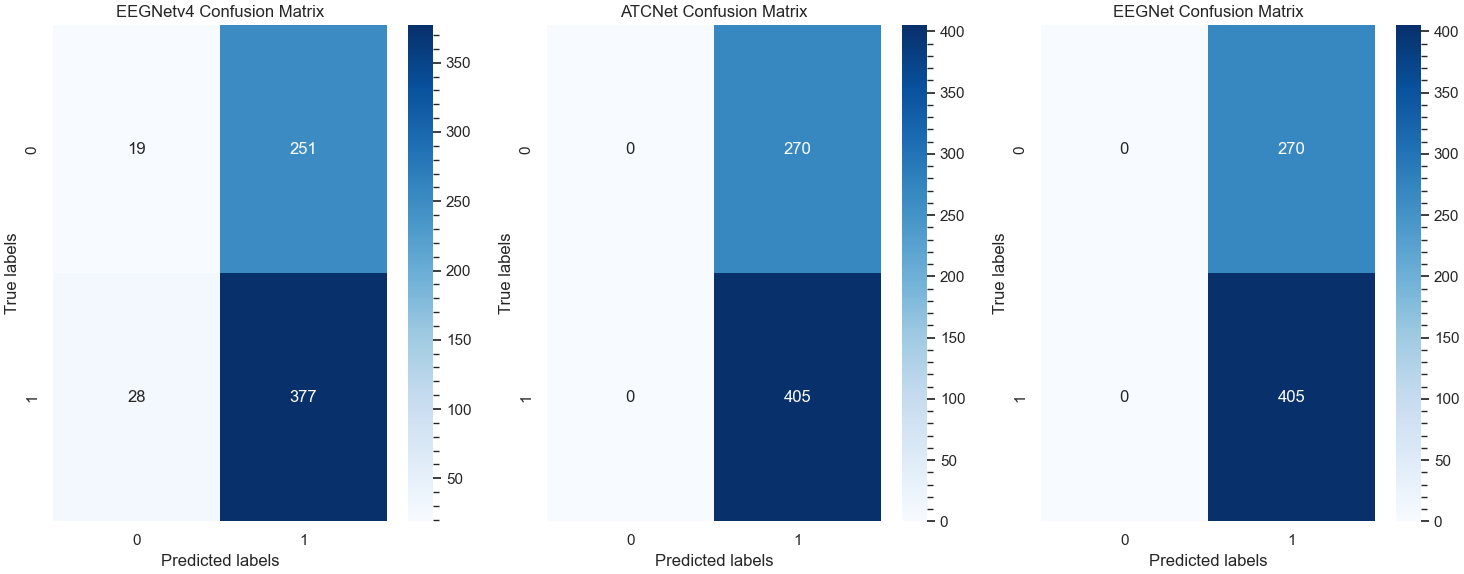

In [33]:
def evaluate_model(model, data_loader, device):
    """ Evaluate the model on the given data loader.
    Args:
        - model: The model to evaluate.
        - data_loader: DataLoader for the evaluation data.
        - device: Device to evaluate the model on.
    Returns:
        - loss: The loss of the model.
        - metrics: List of metrics for the model."""
    model.eval()
    model.to(device)
    loss = 0
    preds = []
    labels = []

    with torch.no_grad():
        for inputs, target in data_loader:
            inputs, target = inputs.to(device), target.to(device)
            output = model(inputs)
            loss += criterion(output, target).item()
            preds.extend(torch.argmax(output, dim=1).cpu().numpy())
            labels.extend(target.cpu().numpy())

    loss /= len(data_loader)
    return loss, preds, labels

def evaluatate_netrics(y_pred, y_true, ax = None):
    """ Evaluate the model on the given data loader.
    Args:
        - y_pred: The predicted labels.
        - y_true: The true labels.
    Returns:
        - f1_score: The F1 score of the model.
        - accuracy: The accuracy of the model.
        - recall: The recall of the model.
        - precision: The precision of the model."""
    f1 = f1_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_pred, average='weighted')
    metrics = pd.DataFrame({
        'F1 Score': [f1],
        'Accuracy': [accuracy],
        'Recall': [recall],
        'Precision': [precision], 
        'AUC Score': [auc_score]})
    
    if ax:
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_xlabel('Predicted labels')
        ax.set_ylabel('True labels')
    return metrics

# Evaluate the models
test_loader_eegnet = create_data_loader(X_test, y_test, batch_size=BATCH_SIZE, shuffle=False, reshape=True)
eegnet_loss, preds_eeg, labels_eeg = evaluate_model(eegnet, test_loader_eegnet, device)
eegnetv4_loss, preds_eeg4, labels_eeg4 = evaluate_model(eegnetv4, test_loader, device)
atcnet_loss, preds_atc, labels_atc = evaluate_model(atcnet, test_loader, device)

fig, ax = plt.subplots(1, 3, figsize=(15, 6))
metrics_eeg4 = evaluatate_netrics(preds_eeg4, labels_eeg4, ax=ax[0])
ax[0].set_title('EEGNetv4 Confusion Matrix')
metrics_atc = evaluatate_netrics(preds_atc, labels_atc, ax=ax[1])
ax[1].set_title('ATCNet Confusion Matrix')
metrics_eeg = evaluatate_netrics(preds_eeg, labels_eeg, ax=ax[2])
ax[2].set_title('EEGNet Confusion Matrix')

# save the metrics
if not os.path.exists('TEST_METRICS'):
    os.makedirs('TEST_METRICS')
metrics_eeg4.to_csv('TEST_METRICS/metrics_eeg4.csv')
metrics_atc.to_csv('TEST_METRICS/metrics_atc.csv')
metrics_eeg.to_csv('TEST_METRICS/metrics_eeg.csv')

print("EEGNetv4 Metrics: \n", metrics_eeg4)
print("ATCNet Metrics: \n", metrics_atc)
print("EEGNet Metrics: \n", metrics_eeg)

plt.tight_layout()

### EEGNET and ATCNET Performance:

- Both models perform poorly on the dataset, yielding only 50% accuracy and low values of other metrics.
- This may be due to the small number of samples (36 only).
- The models mostly guess the Class 1, leading to low performance metrics.
- Further improvement may be achieved using cross-validation and further hyperparameter tuning and dimensionality reduction using an autoencoder or PCA.
- Carefully crafting some other features from the PSD values may also help in improving the performance of the models.